### Libraries

In [1]:
import glob
import os
import pandas as pd

import numpy as np
from tqdm import tqdm

from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss

import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore")

___
### Выгрузка данных 

In [2]:
survey_fcasts = pd.DataFrame()

file_type = 'csv'
seperator =','

for f in glob.glob("*." + file_type):
    if f[:13] == 'survey_fcasts':
        data = pd.read_csv(f, sep=seperator, low_memory=False, encoding='ISO-8859-1')
        survey_fcasts = pd.concat([survey_fcasts, data])
    

ifps = pd.read_csv('ifps.csv', sep=seperator, encoding='ISO-8859-1')

In [3]:
survey_fcasts.head(5)

,ifp_id,ctt,cond,training,team,user_id,forecast_id,fcast_type,answer_option,value,fcast_date,expertise,q_status,viewtime,year,timestamp
0,1004-0,1a,1,a,NaN,600.0,-200987.0,0,a,0.10,2011-08-31,1.0,closed,NaN,1,2011-08-31 16:17:18
1,1004-0,1a,1,a,NaN,600.0,-200987.0,0,b,0.90,2011-08-31,1.0,closed,NaN,1,2011-08-31 16:17:18
2,1008-0,1a,1,a,NaN,600.0,-200986.0,0,a,0.25,2011-08-31,2.0,closed,NaN,1,2011-08-31 16:18:27
3,1008-0,1a,1,a,NaN,600.0,-200986.0,0,b,0.75,2011-08-31,2.0,closed,NaN,1,2011-08-31 16:18:27
4,1006-0,1a,1,a,NaN,600.0,-200985.0,0,a,0.10,2011-08-31,3.0,closed,NaN,1,2011-08-31 16:18:47


In [4]:
ifps.head(5)

,ifp_id,q_type,q_text,q_desc,q_status,date_start,date_suspend,date_to_close,date_closed,outcome,short_title,days_open,n_opts,options
0,1001-0,0,"Will the Six-Party talks (among the US, North ...",'In' refers to any time during the remainder o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/2/12,b,Six-party talks resume,123.0,2,"(a) Yes, (b) No"
1,1002-0,0,Who will be inaugurated as President of Russia...,'In' refers to any time during the 2012 calend...,closed,9/1/11,5/14/12 0:00,5/15/12,5/6/12,b,president of Russia,248.0,3,"(a) Medvedev, (b) Putin, (c) Neither"
2,1003-0,0,Will Serbia be officially granted EU candidacy...,A 'yes' answer to this question requires not o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/3/12,b,Serbia EU candidacy,124.0,2,"(a) Yes, (b) No"
3,1004-0,0,Will the United Nations General Assembly recog...,'By' means at or prior to the end of the day o...,closed,9/1/11,9/29/11 0:00,9/30/11,9/30/11,b,UN-GA recognize Palestine,29.0,2,"(a) Yes, (b) No"
4,1005-0,0,Will Daniel Ortega win another term as Preside...,If the Nicaraguan elections do not occur in la...,closed,9/1/11,11/4/11 0:00,11/5/11,11/5/11,a,Ortega win in Nicaragua,65.0,2,"(a) Yes, (b) No"


In [5]:
q_ifps = pd.DataFrame(ifps['q_text'].unique(), columns=['questions'])
unique_q_num = q_ifps.nunique()

# show some of them
(
q_ifps.questions[0], 
q_ifps.questions[391], 
q_ifps.questions[200] 
)

('Will the Six-Party talks (among the US, North Korea, South Korea, Russia, China, and Japan) formally resume in 2011?',
 'Will **national military force(s) from one or more countries *intervene in Syria **before 1 December 2014?',
 'When will Mariano Rajoy vacate the office of Prime Minister of Spain?')

In [6]:
f'Всего вопросов : {unique_q_num[0]}'

'Всего вопросов : 527'

___
### Предсказание людей в зависимости от их ответа в прошлый год

In [7]:
user_answers = survey_fcasts[['ifp_id','user_id','q_status','year','answer_option','timestamp','value','fcast_type','fcast_date']]
user_answers = user_answers[(~user_answers.user_id.isna()) & (user_answers.q_status == 'closed')].reset_index(drop=True)

user_answers['ans_type'] = user_answers.ifp_id.apply(lambda x: x[5:]).astype(int)
user_answers['question'] = user_answers.ifp_id.apply(lambda x: x[:4]).astype(int)

assert user_answers.user_id.apply(lambda x: x.is_integer()).sum() == user_answers.shape[0]

user_answers['user_id'] = user_answers['user_id'].astype(int)
user_answers = user_answers.sort_values(['question','user_id'])

In [8]:
user_answers.head(2)

,ifp_id,user_id,q_status,year,answer_option,timestamp,value,fcast_type,fcast_date,ans_type,question
5555,1001-0,3,closed,1,a,2011-09-06 05:46:12,0.5,1,2011-09-06,0,1001
5556,1001-0,3,closed,1,b,2011-09-06 05:46:12,0.5,1,2011-09-06,0,1001


In [9]:
mask = (ifps.q_status == 'closed') & (ifps.n_opts == 2) & (ifps.q_type == 0)
question_answers = ifps[mask][['ifp_id','outcome','date_closed']]
assert question_answers.ifp_id.nunique() == question_answers.shape[0]

In [10]:
question_answers.head(2)

,ifp_id,outcome,date_closed
0,1001-0,b,1/2/12
2,1003-0,b,1/3/12


### Creating final DataFrame

In [11]:
ans = question_answers.merge(user_answers, on='ifp_id', how='inner').drop(['q_status', 'ans_type', 'question'], axis=1)
ans.timestamp = ans.timestamp.astype('datetime64[ns]')
ans["outcome"] = (ans["outcome"] == "a").astype(int)
ans = ans.query('answer_option == "a"')

ans["date_closed"] = pd.to_datetime(ans["date_closed"]) + pd.Timedelta(days=1)
ans.dropna(subset=["user_id"], inplace = True)

ans["user_id"] = ans["user_id"].astype(int).astype(str)
ans["days_until_closure"] = (ans["date_closed"] - ans["timestamp"]).dt.days

master_data = ans.query("days_until_closure > 15").sort_values('fcast_date').groupby(['ifp_id', 'user_id']).tail(1)

In [12]:
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
sent_embeddings = model.encode(ifps.q_text)
embedding_df = pd.DataFrame(sent_embeddings)
embedding_df["ifp_id"] = ifps.ifp_id

---
# Fitting models with features related to questions text

In [13]:
event_outcomes = master_data.groupby("ifp_id").outcome.max().reset_index()
expert_inputs = master_data.pivot(index = "ifp_id", columns = "user_id", values = "value").fillna(0)
final_ans = pd.merge(pd.merge(expert_inputs, event_outcomes, on="ifp_id"), embedding_df, on="ifp_id")

In [170]:
final_ans.head(2)

,ifp_id,1000,10001,10010,10014,10016,10034,10043,10046,10049,...,758,759,760,761,762,763,764,765,766,767
0,1001-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.012801,0.054331,-0.003304,0.056317,-0.032626,-0.003777,-0.126869,0.005910,-0.014981,0.071226
1,1003-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.089883,0.073422,-0.009131,0.026745,0.032391,0.011453,-0.046191,0.044056,0.023257,0.072150


### Spliting dataframe on train and test

In [22]:
from sklearn.model_selection import train_test_split

In [52]:
X = final_ans.drop(['ifp_id', 'outcome'], axis=1)
y = final_ans['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Кросс-валидация и grid-search (для стабильности)

$$ 
ElasticNetMSE = MSE(y, y_{pred}) + С \cdot (1 - L_{1}Ratio) \sum_{i=1}^{m} \lvert{\theta_{i}}\rvert +  С \cdot (1 - L_{1}Ratio)\sum_{i=1}^{m} \lvert{\theta_{i}}\rvert ,
$$

Where hyperparameters:

* `C` -  This parameter signifies strength of the regularization and takes a positive float value.
* `l1_ratio` -  the penalty will be a combination of l1 & l2, l1_ratio fraction will define the weight of l1 in the mix.
* `penalty` - elasticnet : penalty only supported by: saga solver.
* `solver` - Saga is a variant of Sag and it can be used with l1 Regularization. It’s a quite time-efficient solver and usually the go-to solver with very large datasets.



In [27]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
k_fold = KFold(n_splits=4)
parameters = {
    'C'         : np.geomspace(0.01, 5, 20),
    'penalty'   : ['elasticnet'], 
    'solver'    : ['saga'],    
}

In [79]:
%%time
lr = LogisticRegression(max_iter= 350, l1_ratio=0,  random_state=12, n_jobs=-1)
clf_0 = GridSearchCV(lr, parameters, cv=k_fold, scoring='neg_brier_score')

clf_0.fit(X_train, y_train)
clf_0.best_estimator_

Wall time: 9min 4s


LogisticRegression(C=0.3652259113562679, l1_ratio=0, max_iter=350, n_jobs=-1,
                   penalty='elasticnet', random_state=12, solver='saga')

In [80]:
%%time
lr = LogisticRegression(max_iter= 350, l1_ratio=0.33,  random_state=12, n_jobs=-1)
clf_33 = GridSearchCV(lr, parameters, cv=k_fold, scoring='neg_brier_score')

clf_33.fit(X_train, y_train)
clf_33.best_estimator_

Wall time: 10min 6s


LogisticRegression(C=0.5065387033533725, l1_ratio=0.33, max_iter=350, n_jobs=-1,
                   penalty='elasticnet', random_state=12, solver='saga')

In [81]:
%%time
lr = LogisticRegression(max_iter= 350, l1_ratio=0.66,  random_state=12, n_jobs=-1)
clf_66 = GridSearchCV(lr, parameters, cv=k_fold, scoring='neg_brier_score')

clf_66.fit(X_train, y_train)
clf_66.best_estimator_

Wall time: 9min 1s


LogisticRegression(C=0.9743494403440248, l1_ratio=0.66, max_iter=350, n_jobs=-1,
                   penalty='elasticnet', random_state=12, solver='saga')

In [82]:
%%time
lr = LogisticRegression(max_iter= 350, l1_ratio=1,  random_state=12, n_jobs=-1)
clf_1 = GridSearchCV(lr, parameters, cv=k_fold, scoring='neg_brier_score')

clf_1.fit(X_train, y_train)
clf_1.best_estimator_

Wall time: 23min 39s


LogisticRegression(C=1.8742039366662617, l1_ratio=1, max_iter=350, n_jobs=-1,
                   penalty='elasticnet', random_state=12, solver='saga')

In [117]:
clf_l1_diff = [clf_0, clf_33, clf_66, clf_1]
plot_names = [
    'L1_ration = 0 (L2 regularization)',
    'L1_ratio = 0.33',
    'L1_ratio = 0.66',
    'L1_ration = 1 (L1 regularization)',
]

In [137]:
def plot_res(
    plot_data : pd.DataFrame, 
    name      : 'str',
    ax,
) -> None:
    plot_res = pd.DataFrame(plot_data.cv_results_)

    plt.title(name, fontsize=16, loc='left')

    plt.plot(plot_res['param_C'], -plot_res['mean_test_score'])
    plt.scatter(plot_data.best_params_['C'], -plot_data.best_score_, color='red', linewidths=5, alpha=1)

    plt.xlabel('C regularizaton parameter', fontsize=14)
    plt.ylabel('Brier Score', fontsize=14)
    plt.grid()

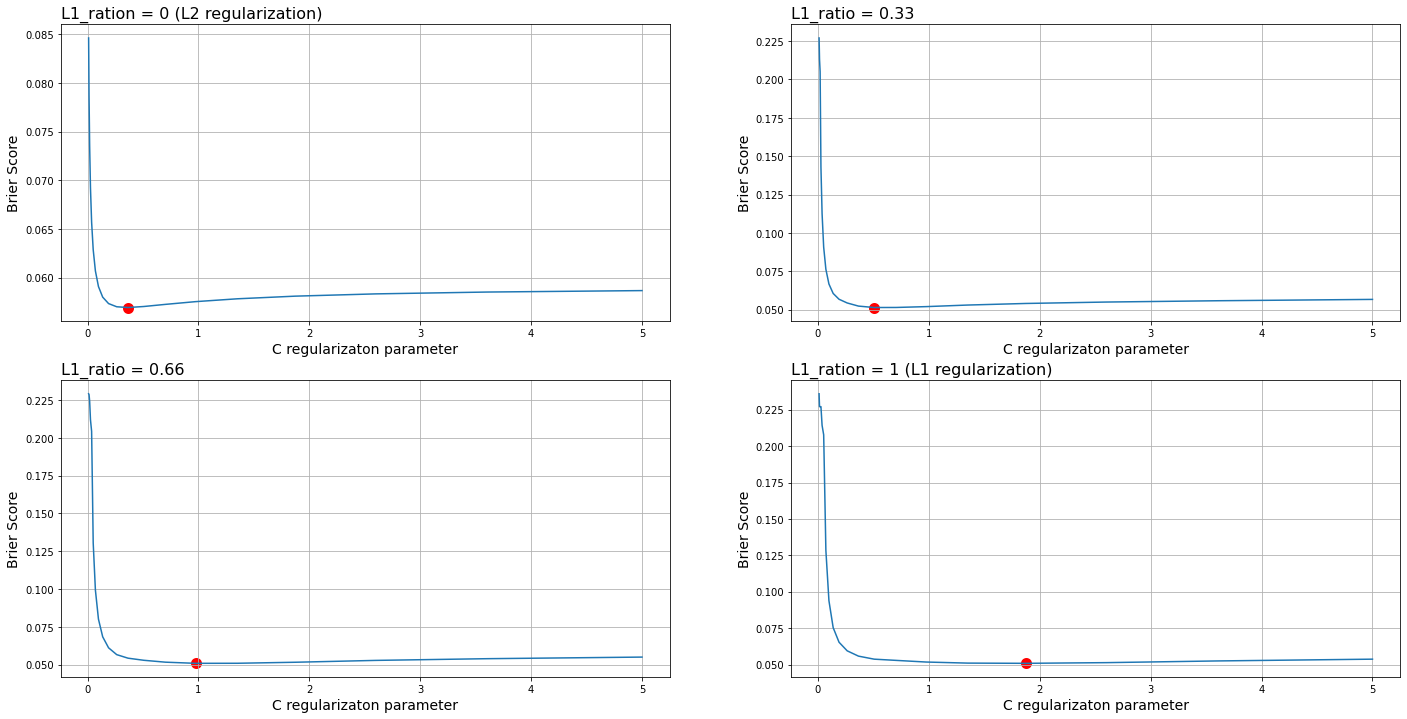

In [138]:
fig = plt.figure(figsize=(24, 12))

for i in [0, 1, 2, 3]:
    plot_res(clf_l1_diff[i], plot_names[i], ax= plt.subplot(2, 2, i+1))

---
#### Prediction in Test sample

In [166]:
row_names = [0, 0.33, 0.66, 1]
bss = [0, 0, 0, 0]

for i in [0, 1, 2, 3]:
    y_prob = clf_l1_diff[i].predict_proba(X_test)[:, 1]
    bss[i] = brier_score_loss(y_test, y_prob)
    
pd.DataFrame({'l1_ratio':row_names, 'brier_score':bss})

,l1_ratio,brier_score
0,0.00,0.046598
1,0.33,0.048822
2,0.66,0.051017
3,1.00,0.053569


---
# Model fitting without features related to questions text

In [167]:
final_ans_no_words = pd.merge(expert_inputs, event_outcomes, on="ifp_id")

In [169]:
X = final_ans_no_words.drop(['ifp_id', 'outcome'], axis=1)
y = final_ans_no_words['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

In [172]:
k_fold = KFold(n_splits=4)
parameters = {
    'C'         : np.geomspace(0.01, 5, 20),
    'penalty'   : ['elasticnet'], 
    'solver'    : ['saga'],    
}

###############

lr = LogisticRegression(max_iter= 350, l1_ratio=0,  random_state=12, n_jobs=-1)
clf_0 = GridSearchCV(lr, parameters, cv=k_fold, scoring='neg_brier_score')
clf_0.fit(X_train, y_train)

###############

lr = LogisticRegression(max_iter= 350, l1_ratio=0.33,  random_state=12, n_jobs=-1)
clf_33 = GridSearchCV(lr, parameters, cv=k_fold, scoring='neg_brier_score')
clf_33.fit(X_train, y_train)

###############

lr = LogisticRegression(max_iter= 350, l1_ratio=0.66,  random_state=12, n_jobs=-1)
clf_66 = GridSearchCV(lr, parameters, cv=k_fold, scoring='neg_brier_score')
clf_66.fit(X_train, y_train)

###############
lr = LogisticRegression(max_iter= 350, l1_ratio=1,  random_state=12, n_jobs=-1)
clf_1 = GridSearchCV(lr, parameters, cv=k_fold, scoring='neg_brier_score')
clf_1.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=LogisticRegression(l1_ratio=1, max_iter=350, n_jobs=-1,
                                          random_state=12),
             param_grid={'C': array([0.01      , 0.01386919, 0.01923544, 0.02667799, 0.03700021,
       0.05131629, 0.07117153, 0.09870914, 0.13690157, 0.18987137,
       0.26333618, 0.36522591, 0.5065387 , 0.70252808, 0.97434944,
       1.35134361, 1.87420394, 2.59936878, 3.60511358, 5.        ]),
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             scoring='neg_brier_score')

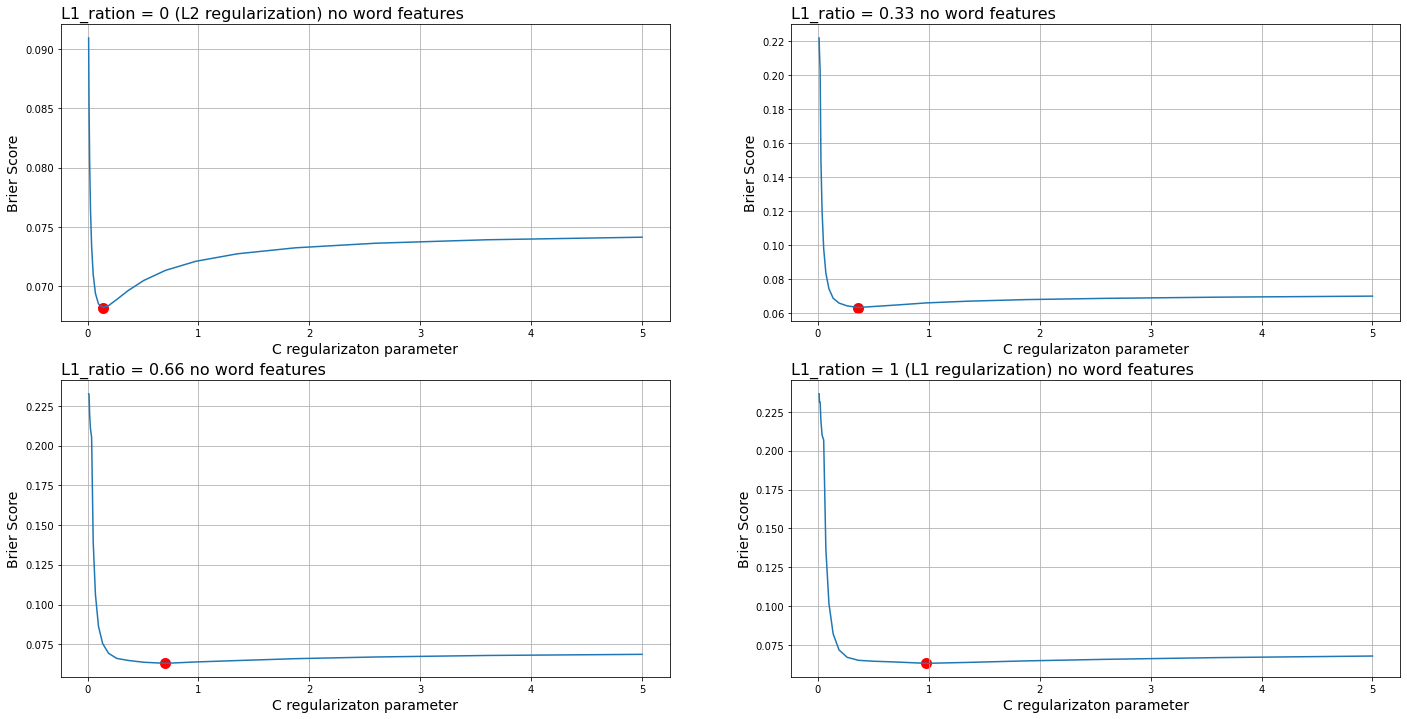

In [173]:
clf_l1_diff = [clf_0, clf_33, clf_66, clf_1]

plot_names = [
    'L1_ration = 0 (L2 regularization) no word features',
    'L1_ratio = 0.33 no word features',
    'L1_ratio = 0.66 no word features',
    'L1_ration = 1 (L1 regularization) no word features',
]

fig = plt.figure(figsize=(24, 12))

for i in [0, 1, 2, 3]:
    plot_res(clf_l1_diff[i], plot_names[i], ax= plt.subplot(2, 2, i+1))

---
#### Prediction in Test sample

In [174]:
row_names = [0, 0.33, 0.66, 1]
bss = [0, 0, 0, 0]

for i in [0, 1, 2, 3]:
    y_prob = clf_l1_diff[i].predict_proba(X_test)[:, 1]
    bss[i] = brier_score_loss(y_test, y_prob)
    
pd.DataFrame({'l1_ratio':row_names, 'brier_score':bss})

,l1_ratio,brier_score
0,0.00,0.037447
1,0.33,0.035167
2,0.66,0.034673
3,1.00,0.035026
